<a href="https://colab.research.google.com/github/aurumkathuria/PPP-Fraud/blob/main/PPP_Fraud_TAMU_Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 
from IPython.display import clear_output
!pip install bdtk PyOD -q
from bdtk import BDTK
from pyod.models import loda, sos

%matplotlib inline

In [ ]:
# prep plotting aesthetics
#set font size names
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22
#set font sizes
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#set figure size
plt.rcParams['figure.figsize'] = (15, 10)

# Body of Work

## Data Imports

In [ ]:
# Data Source: https://home.treasury.gov/policy-issues/cares-act/assistance-for-small-businesses/sba-paycheck-protection-program-loan-level-data
og_df = pd.read_csv("/content/PPP_data_150k_plus.csv", encoding='utf8')
og_df

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsReported,DateApproved,Lender,CD
0,"d $350,000-1 million",AERO BOX LLC,NaN,NaN,NaN,NaN,484210.0,NaN,Unanswered,Unanswered,Unanswered,NaN,NaN,05/03/2020,The Huntington National Bank,NaN
1,"d $350,000-1 million",BOYER CHILDREN'S CLINIC,1850 BOYER AVE E,SEATTLE,NaN,98112.0,NaN,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,75.0,05/03/2020,"Bank of America, National Association",WA-07
2,"d $350,000-1 million",KIRTLEY CONSTRUCTION INC,1661 MARTIN RANCH RD,SAN BERNARDINO,NaN,92407.0,236115.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,21.0,05/03/2020,"Bank of America, National Association",CA-31
3,"d $350,000-1 million","PLEASANT PLACES, INC.",7684 Southrail Road,North Charleston,NaN,29420.0,561730.0,Sole Proprietorship,Unanswered,Male Owned,Non-Veteran,NaN,73.0,05/03/2020,Synovus Bank,SC-01
4,"d $350,000-1 million","SUMTER COATINGS, INC.",2410 Highway 15 South,Sumter,NaN,29150.0,325510.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,62.0,05/03/2020,Synovus Bank,SC-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662510,"e $150,000-350,000",YMCA OF NATRONA COUNTY,1161 Casper Mountain Road,CASPER,WY,82601.0,624190.0,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,70.0,04/16/2020,First Interstate Bank,WY-00
662511,"e $150,000-350,000",YOR RESTAURANT GROUP,72 South Glenwood Street,Jackson,WY,83001.0,722511.0,Subchapter S Corporation,Unanswered,Male Owned,Unanswered,NaN,15.0,05/19/2020,Celtic Bank Corporation,WY-00
662512,"e $150,000-350,000","YOUTH CRISIS CENTER, INC.",1656 E 12th Street,CASPER,WY,82601.0,624190.0,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,19.0,04/10/2020,First Interstate Bank,WY-00
662513,"e $150,000-350,000","ZOCO UNLIMITED, INC.",PO BOX 305 3 CR 700,BAGGS,WY,82321.0,213112.0,Subchapter S Corporation,Unanswered,Male Owned,Unanswered,NaN,19.0,04/27/2020,Bank of Commerce,WY-00


In [ ]:
df = og_df.copy()
for col_name in df.columns:
    display(pd.DataFrame(df[col_name].value_counts()))
    clear_output()

interactive(children=(Dropdown(description='base_column', options=('LoanRange', 'BusinessName', 'Address', 'Ci…

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

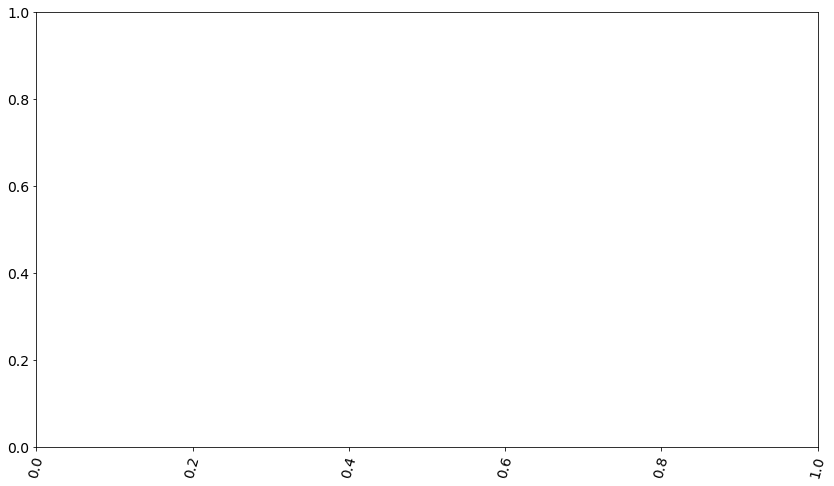

In [ ]:
BDTK(df).interactive_col_dist()
plt.xticks(rotation=75)

In [ ]:
amount_freq = df['LoanRange'].value_counts()
# sns.barplot   (x=amount_freq.index.values, orient='vertical')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


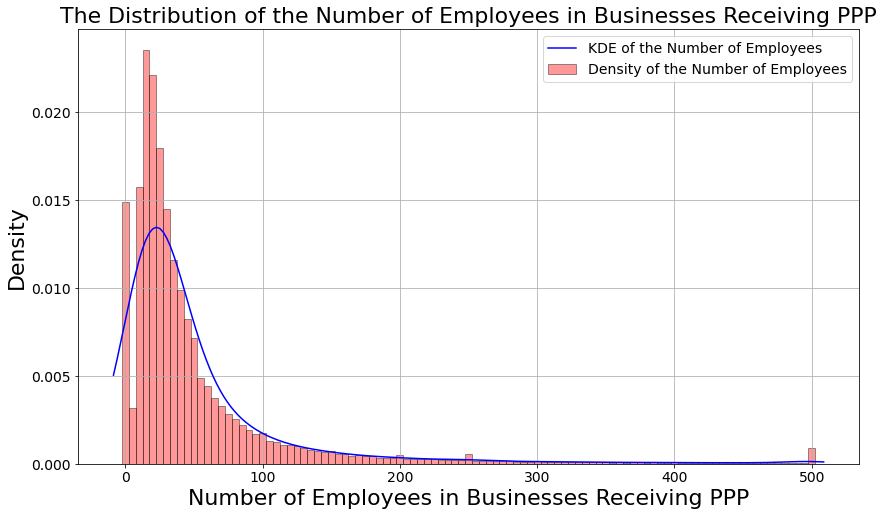

In [ ]:
custom_bins = np.arange(-2.5, 502.5+1, 5)
sns.distplot(df['JobsReported'], bins=custom_bins, 
             hist_kws={'histtype': 'bar', 'ec': 'black'}, color='red',
             kde_kws={'bw_method': 0.25, 'cut': 0.5,
                      'color': 'blue', 'label': 'KDE of the Number of Employees',},
             label='Density of the Number of Employees')
plt.title('The Distribution of the Number of Employees in Businesses Receiving PPP')
plt.xlabel('Number of Employees in Businesses Receiving PPP')
plt.ylabel('Density')
plt.grid()
plt.legend()
None

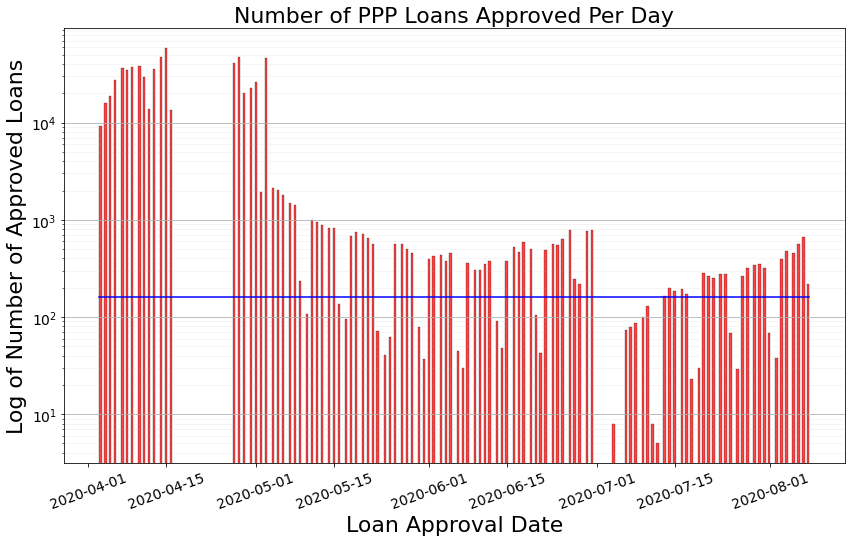

In [ ]:
dates = pd.to_datetime(df['DateApproved'])
sns.histplot(dates, label='PPP Loans Approved (Daily Count)', color='red')
unique_dates = np.unique(dates)
plt.plot(unique_dates, np.ones(len(unique_dates)) * (58000/365), color='blue')
plt.xticks(rotation=20)
plt.yscale('log')
plt.title('Number of PPP Loans Approved Per Day')
plt.xlabel('Loan Approval Date')
plt.ylabel('Log of Number of Approved Loans')
plt.grid(which='major', axis='y')
plt.grid(which='minor', axis='y', alpha=0.15)
None

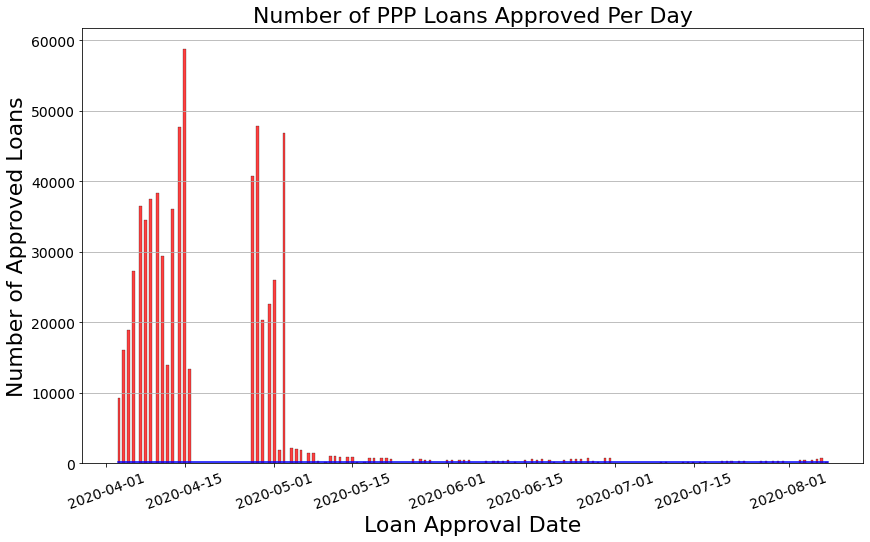

In [ ]:
dates = pd.to_datetime(df['DateApproved'])
sns.histplot(dates, label='PPP Loans Approved (Daily Count)', color='red')
unique_dates = np.unique(dates)
plt.plot(unique_dates, np.ones(len(unique_dates)) * (58000/365), color='blue')
plt.xticks(rotation=20, )
plt.title('Number of PPP Loans Approved Per Day')
plt.xlabel('Loan Approval Date')
plt.ylabel('Number of Approved Loans')
plt.grid(which='major', axis='y')
plt.grid(which='minor', axis='y', alpha=0.5)
None

## What's Up With That Weird Spike at 500?

That's the question I found myself asking when observing what seems to be an otherwise very well-behaved Gamma distribution. Looking closely at the rules of the PPP Program, businesses with over 500 employees are not eligible for PPP. There are a few possible explanations I came up with:

1) There are external forces that push businesses in specific industries to have no more than 500 (or 250, or 200) employees. I couldn't find any federal/cross-industry initiatives that motivated businesses to keep headcount at or below 500. 

2) Businesses of under but close to 500 people are reporting themselves as having 500 employees because of difficulties pinpointing a specific number of payrolled employees through a wide date range.

3) Businesses of over 500 people are submitting applications as if they're only 500 people strong, so that they would be eligible for PPP funding.

4) Businesses of under but close to 500 people are reporting themselves as having 500 employees because of a desire to get additional loan money.

Nonetheless, the spikes there, at 250, and 200, should be examined in greater detail to understand why it is the case.

Let's see if we can use anomaly detection to identify some possibly dubious loans that may need a second look.

### First, Let's Clean & Prep The Dataset

In [ ]:
df = df.apply(lambda arr: pd.Series(arr).apply(lambda item: {'Unanswered': pd.NA, np.nan: pd.NA}.get(item, item)))
df

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsReported,DateApproved,Lender,CD
0,"d $350,000-1 million",AERO BOX LLC,<NA>,<NA>,<NA>,NaN,484210.0,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,05/03/2020,The Huntington National Bank,<NA>
1,"d $350,000-1 million",BOYER CHILDREN'S CLINIC,1850 BOYER AVE E,SEATTLE,<NA>,98112.0,NaN,Non-Profit Organization,<NA>,<NA>,<NA>,Y,75.0,05/03/2020,"Bank of America, National Association",WA-07
2,"d $350,000-1 million",KIRTLEY CONSTRUCTION INC,1661 MARTIN RANCH RD,SAN BERNARDINO,<NA>,92407.0,236115.0,Corporation,<NA>,<NA>,<NA>,<NA>,21.0,05/03/2020,"Bank of America, National Association",CA-31
3,"d $350,000-1 million","PLEASANT PLACES, INC.",7684 Southrail Road,North Charleston,<NA>,29420.0,561730.0,Sole Proprietorship,<NA>,Male Owned,Non-Veteran,<NA>,73.0,05/03/2020,Synovus Bank,SC-01
4,"d $350,000-1 million","SUMTER COATINGS, INC.",2410 Highway 15 South,Sumter,<NA>,29150.0,325510.0,Corporation,<NA>,<NA>,<NA>,<NA>,62.0,05/03/2020,Synovus Bank,SC-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662510,"e $150,000-350,000",YMCA OF NATRONA COUNTY,1161 Casper Mountain Road,CASPER,WY,82601.0,624190.0,Non-Profit Organization,<NA>,<NA>,<NA>,Y,70.0,04/16/2020,First Interstate Bank,WY-00
662511,"e $150,000-350,000",YOR RESTAURANT GROUP,72 South Glenwood Street,Jackson,WY,83001.0,722511.0,Subchapter S Corporation,<NA>,Male Owned,<NA>,<NA>,15.0,05/19/2020,Celtic Bank Corporation,WY-00
662512,"e $150,000-350,000","YOUTH CRISIS CENTER, INC.",1656 E 12th Street,CASPER,WY,82601.0,624190.0,Non-Profit Organization,<NA>,<NA>,<NA>,Y,19.0,04/10/2020,First Interstate Bank,WY-00
662513,"e $150,000-350,000","ZOCO UNLIMITED, INC.",PO BOX 305 3 CR 700,BAGGS,WY,82321.0,213112.0,Subchapter S Corporation,<NA>,Male Owned,<NA>,<NA>,19.0,04/27/2020,Bank of Commerce,WY-00


In [ ]:
pd.DataFrame(np.sum(df.isna(), axis=0)).T

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsReported,DateApproved,Lender,CD
0,0,5,17,15,16,16,6715,1405,568103,471770,522970,620522,39880,0,0,223


In [ ]:
# It seems like most of the data comes pretty clean as is, but the 
# NonProfit, Veteran, Gender, & RaceEthnicity columns are very empty.
# For now, we'll drop them from our data.
df = df.drop(columns=['NonProfit', 'Veteran', 'Gender', 'RaceEthnicity'])

In [ ]:
missing_per_row = pd.DataFrame(np.unique(np.sum(df.isna(), axis=1), return_counts=True)).T
missing_per_row.columns=['# NA', 'Frequency']
missing_per_row = missing_per_row.set_index(keys='# NA')
missing_per_row

,Frequency
# NA,
0,615147
1,46513
2,828
3,12
4,4
6,6
7,5


In [ ]:
# Looks like there's only 15 rows missing more than 3 elements
# Let's take a quick look at them and see if we should remove them outright.
df['# NA'] = np.sum(df.isna(), axis=1)
df[df["# NA"] > 3]

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,JobsReported,DateApproved,Lender,CD,# NA
0,"d $350,000-1 million",AERO BOX LLC,<NA>,<NA>,<NA>,NaN,484210.0,<NA>,NaN,05/03/2020,The Huntington National Bank,<NA>,7
5,"e $150,000-350,000",CHURCH SQUARE PHARMACY INC,<NA>,<NA>,<NA>,NaN,424210.0,Corporation,NaN,05/03/2020,The Huntington National Bank,<NA>,6
6,"e $150,000-350,000",FERNANDINA BEACH HOTEL GROUP LLC,<NA>,<NA>,<NA>,NaN,721110.0,<NA>,NaN,05/03/2020,The Huntington National Bank,<NA>,7
8,"e $150,000-350,000",HUDSON EXTRUSIONS INC.,<NA>,<NA>,<NA>,NaN,326199.0,<NA>,NaN,05/03/2020,The Huntington National Bank,<NA>,7
9,"e $150,000-350,000",MIAMITOWN AUTO PARTS AND RECYCLING INC,<NA>,<NA>,<NA>,NaN,423140.0,Corporation,NaN,05/03/2020,The Huntington National Bank,<NA>,6
10,"e $150,000-350,000","MILFAST INDUSTRIAL SUPPLY, INC",<NA>,<NA>,<NA>,NaN,423840.0,<NA>,18.0,05/03/2020,The Huntington National Bank,<NA>,6
11,"e $150,000-350,000",NOT AVAILABLE,<NA>,<NA>,<NA>,NaN,339114.0,<NA>,17.0,05/03/2020,"Bank of America, National Association",<NA>,6
12,"e $150,000-350,000",NOT AVAILABLE,<NA>,<NA>,<NA>,NaN,339114.0,<NA>,16.0,05/03/2020,"Bank of America, National Association",<NA>,6
13,"e $150,000-350,000",NOT AVAILABLE,<NA>,<NA>,<NA>,NaN,339114.0,<NA>,14.0,05/03/2020,"Bank of America, National Association",<NA>,6
14,"e $150,000-350,000",OTTAWA PRODUCTS CO INC,<NA>,<NA>,<NA>,NaN,332510.0,<NA>,NaN,05/03/2020,The Huntington National Bank,<NA>,7


In [ ]:
# Hmm, we don't care too much about those rows since they're very empty.
# While we're here, let's note that address is almost always unique, and CD
# doesn't carry much new information. Let's drop those columns.
df = df[df["# NA"] < 3]
df = df.drop(columns=['Address', 'CD']).reset_index(drop=True)
df.head()

,LoanRange,BusinessName,City,State,Zip,NAICSCode,BusinessType,JobsReported,DateApproved,Lender,# NA
0,"d $350,000-1 million",BOYER CHILDREN'S CLINIC,SEATTLE,<NA>,98112.0,NaN,Non-Profit Organization,75.0,05/03/2020,"Bank of America, National Association",2
1,"d $350,000-1 million",KIRTLEY CONSTRUCTION INC,SAN BERNARDINO,<NA>,92407.0,236115.0,Corporation,21.0,05/03/2020,"Bank of America, National Association",1
2,"d $350,000-1 million","PLEASANT PLACES, INC.",North Charleston,<NA>,29420.0,561730.0,Sole Proprietorship,73.0,05/03/2020,Synovus Bank,1
3,"d $350,000-1 million","SUMTER COATINGS, INC.",Sumter,<NA>,29150.0,325510.0,Corporation,62.0,05/03/2020,Synovus Bank,1
4,"e $150,000-350,000",FRUIT COVE BAPTIST CHURCH OF JACKSONVILLE FL INC,Saint Johns,<NA>,32259.0,813110.0,Non-Profit Organization,89.0,05/03/2020,Synovus Bank,1


In [ ]:
missing_per_row = pd.DataFrame(np.unique(np.sum(df.isna(), axis=1), return_counts=True)).T
missing_per_row.columns=['# NA', 'Frequency']
missing_per_row = missing_per_row.set_index(keys='# NA')
missing_per_row

,Frequency
# NA,
0,615282
1,46446
2,760


In [ ]:
# Let's take another look at what we're missing, this time as a percentage and raw
missing = np.sum(df.isna(), axis=0)
missing_df = pd.DataFrame(np.round(missing/len(df)*100, 2), columns=['Perc'])
missing_df['Raw'] = np.sum(df.isna(), axis=0)
missing_df.T

,LoanRange,BusinessName,City,State,Zip,NAICSCode,BusinessType,JobsReported,DateApproved,Lender,# NA
Perc,0.0,0.0,0.0,0.0,0.0,1.01,0.21,6.02,0.0,0.0,0.0
Raw,0.0,5.0,0.0,5.0,1.0,6703.00,1388.00,39864.00,0.0,0.0,0.0


In [ ]:
df = df.drop(columns='# NA')

In [ ]:
# We can work with this! Let's move on to building the design matrix
df['Zip'] = df['Zip'].convert_dtypes()
df['NAICSCode'] = df['NAICSCode'].convert_dtypes()
df['JobsReported'] = df['JobsReported'].convert_dtypes()
df.head()

,LoanRange,BusinessName,City,State,Zip,NAICSCode,BusinessType,JobsReported,DateApproved,Lender
0,"d $350,000-1 million",BOYER CHILDREN'S CLINIC,SEATTLE,<NA>,98112,<NA>,Non-Profit Organization,75,05/03/2020,"Bank of America, National Association"
1,"d $350,000-1 million",KIRTLEY CONSTRUCTION INC,SAN BERNARDINO,<NA>,92407,236115,Corporation,21,05/03/2020,"Bank of America, National Association"
2,"d $350,000-1 million","PLEASANT PLACES, INC.",North Charleston,<NA>,29420,561730,Sole Proprietorship,73,05/03/2020,Synovus Bank
3,"d $350,000-1 million","SUMTER COATINGS, INC.",Sumter,<NA>,29150,325510,Corporation,62,05/03/2020,Synovus Bank
4,"e $150,000-350,000",FRUIT COVE BAPTIST CHURCH OF JACKSONVILLE FL INC,Saint Johns,<NA>,32259,813110,Non-Profit Organization,89,05/03/2020,Synovus Bank


In [ ]:
# Business name won't matter much here, again it's usually unique, so let's remove it
df = df.drop(columns='BusinessName')
df.head()

,LoanRange,City,State,Zip,NAICSCode,BusinessType,JobsReported,DateApproved,Lender
0,"d $350,000-1 million",SEATTLE,<NA>,98112,<NA>,Non-Profit Organization,75,05/03/2020,"Bank of America, National Association"
1,"d $350,000-1 million",SAN BERNARDINO,<NA>,92407,236115,Corporation,21,05/03/2020,"Bank of America, National Association"
2,"d $350,000-1 million",North Charleston,<NA>,29420,561730,Sole Proprietorship,73,05/03/2020,Synovus Bank
3,"d $350,000-1 million",Sumter,<NA>,29150,325510,Corporation,62,05/03/2020,Synovus Bank
4,"e $150,000-350,000",Saint Johns,<NA>,32259,813110,Non-Profit Organization,89,05/03/2020,Synovus Bank


In [ ]:
# Let's clean up the city name
df['City'] = df['City'].str.lower()
df.head()

,LoanRange,City,State,Zip,NAICSCode,BusinessType,JobsReported,DateApproved,Lender
0,"d $350,000-1 million",seattle,<NA>,98112,<NA>,Non-Profit Organization,75,05/03/2020,"Bank of America, National Association"
1,"d $350,000-1 million",san bernardino,<NA>,92407,236115,Corporation,21,05/03/2020,"Bank of America, National Association"
2,"d $350,000-1 million",north charleston,<NA>,29420,561730,Sole Proprietorship,73,05/03/2020,Synovus Bank
3,"d $350,000-1 million",sumter,<NA>,29150,325510,Corporation,62,05/03/2020,Synovus Bank
4,"e $150,000-350,000",saint johns,<NA>,32259,813110,Non-Profit Organization,89,05/03/2020,Synovus Bank


In [ ]:
# We can't one-hot encode 'City' without killing our RAM usage, so we'll just drop that
# The same goes for 'NAICSCode' and for 'Zip'
df = df.drop(columns=['Zip', 'NAICSCode'])
df.head()

,LoanRange,City,State,BusinessType,JobsReported,DateApproved,Lender
0,"d $350,000-1 million",seattle,<NA>,Non-Profit Organization,75,05/03/2020,"Bank of America, National Association"
1,"d $350,000-1 million",san bernardino,<NA>,Corporation,21,05/03/2020,"Bank of America, National Association"
2,"d $350,000-1 million",north charleston,<NA>,Sole Proprietorship,73,05/03/2020,Synovus Bank
3,"d $350,000-1 million",sumter,<NA>,Corporation,62,05/03/2020,Synovus Bank
4,"e $150,000-350,000",saint johns,<NA>,Non-Profit Organization,89,05/03/2020,Synovus Bank


In [ ]:
# Transform 'DateApproved' into a more workable month column
#df['DateApproved'] = 
df['Month'] = pd.to_datetime(df['DateApproved'], errors='coerce').dt.month
df = df.drop(columns='DateApproved')
df.head()

,LoanRange,City,State,BusinessType,JobsReported,Lender,Month
0,"d $350,000-1 million",seattle,<NA>,Non-Profit Organization,75,"Bank of America, National Association",5
1,"d $350,000-1 million",san bernardino,<NA>,Corporation,21,"Bank of America, National Association",5
2,"d $350,000-1 million",north charleston,<NA>,Sole Proprietorship,73,Synovus Bank,5
3,"d $350,000-1 million",sumter,<NA>,Corporation,62,Synovus Bank,5
4,"e $150,000-350,000",saint johns,<NA>,Non-Profit Organization,89,Synovus Bank,5


In [ ]:
lender_loan_count = df['Lender'].value_counts()
lender_loan_count = pd.DataFrame(lender_loan_count).reset_index()
lender_loan_count.columns = ['Lender', 'NumLoansByLender']
df = df.merge(lender_loan_count, on='Lender')
df.head()

,LoanRange,City,State,BusinessType,JobsReported,Lender,Month,NumLoansByLender
0,"d $350,000-1 million",seattle,<NA>,Non-Profit Organization,75,"Bank of America, National Association",5,29793
1,"d $350,000-1 million",san bernardino,<NA>,Corporation,21,"Bank of America, National Association",5,29793
2,b $2-5 million,anchorage,AK,<NA>,135,"Bank of America, National Association",5,29793
3,b $2-5 million,anchorage,AK,Corporation,180,"Bank of America, National Association",4,29793
4,b $2-5 million,anchorage,AK,Corporation,216,"Bank of America, National Association",4,29793


In [ ]:
df.to_csv('processed_data.csv')

In [ ]:
# df = pd.read_csv('processed_data.csv', index_col=0)

In [ ]:
# Do One-Hot Encoding where possible
df = pd.get_dummies(df, prefix=['Month', 'State', 'Biz'], columns=['Month', 'State', 'BusinessType'])
print(df.shape)
df.head()

(662488, 83)


,LoanRange,City,JobsReported,Lender,NumLoansByLender,Month_4,Month_5,Month_6,Month_7,Month_8,State_AK,State_AL,State_AR,State_AS,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_GU,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MP,State_MS,State_MT,...,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_PR,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VI,State_VT,State_WA,State_WI,State_WV,State_WY,Biz_Cooperative,Biz_Corporation,Biz_Employee Stock Ownership Plan(ESOP),Biz_Independent Contractors,Biz_Joint Venture,Biz_Limited Liability Company(LLC),Biz_Limited Liability Partnership,Biz_Non-Profit Childcare Center,Biz_Non-Profit Organization,Biz_Partnership,Biz_Professional Association,Biz_Rollover as Business Start-Ups (ROB,Biz_Self-Employed Individuals,Biz_Sole Proprietorship,Biz_Subchapter S Corporation,Biz_Tenant in Common,Biz_Trust
0,"d $350,000-1 million",seattle,75,"Bank of America, National Association",29793,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,"d $350,000-1 million",san bernardino,21,"Bank of America, National Association",29793,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,b $2-5 million,anchorage,135,"Bank of America, National Association",29793,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,b $2-5 million,anchorage,180,"Bank of America, National Association",29793,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,b $2-5 million,anchorage,216,"Bank of America, National Association",29793,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = df.drop(columns=['City', 'Lender'])
lower_bounds = {'a': 5.000, 'b': 2.000, 'c': 1.000, 'd': 0.350, 'e': 0.150}
upper_bounds = {'a': 10.000, 'b': 5.000, 'c': 2.000, 'd': 1.000, 'e': 0.350}
df['LoanLowerBound'] = df['LoanRange'].apply(lambda val: lower_bounds.get(str(val).strip()[0]))
df['LoanUpperBound'] = df['LoanRange'].apply(lambda val: upper_bounds.get(str(val).strip()[0]))
df = df.drop(columns='LoanRange')
df.head()

,JobsReported,NumLoansByLender,Month_4,Month_5,Month_6,Month_7,Month_8,State_AK,State_AL,State_AR,State_AS,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_GU,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MP,State_MS,State_MT,State_NC,State_ND,State_NE,...,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_PR,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VI,State_VT,State_WA,State_WI,State_WV,State_WY,Biz_Cooperative,Biz_Corporation,Biz_Employee Stock Ownership Plan(ESOP),Biz_Independent Contractors,Biz_Joint Venture,Biz_Limited Liability Company(LLC),Biz_Limited Liability Partnership,Biz_Non-Profit Childcare Center,Biz_Non-Profit Organization,Biz_Partnership,Biz_Professional Association,Biz_Rollover as Business Start-Ups (ROB,Biz_Self-Employed Individuals,Biz_Sole Proprietorship,Biz_Subchapter S Corporation,Biz_Tenant in Common,Biz_Trust,LoanLowerBound,LoanUpperBound
0,75,29793,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.35,1.0
1,21,29793,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.35,1.0
2,135,29793,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.00,5.0
3,180,29793,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.00,5.0
4,216,29793,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.00,5.0


In [ ]:
# Fill in missing JobsReported with a 0
df['JobsReported'] = df['JobsReported'].fillna(0)

In [ ]:
clf = loda.LODA(contamination=0.1)
clf.fit(df)
anomaly_scores = clf.decision_function(df)
anomaly_scores

array([0.09924032, 0.10038181, 0.11422488, ..., 0.06642712, 0.06383039,
       0.06659072])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


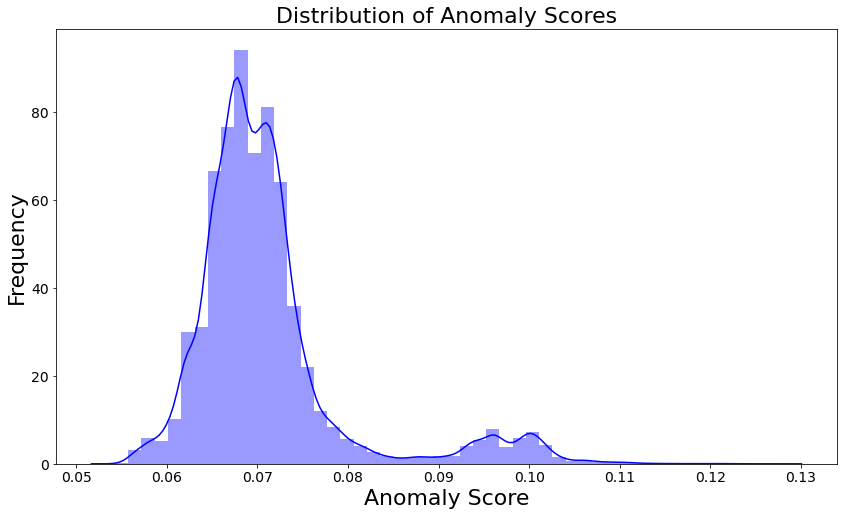

In [ ]:
sns.distplot(anomaly_scores, color='blue', kde_kws={'bw_method': 0.1})
plt.title("Distribution of Anomaly Scores")
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
None

In [ ]:
revisit_indices = np.where(anomaly_scores > 0.09)
print(revisit_indices)

(array([     0,      1,      2, ..., 660059, 660758, 660949]),)


In [ ]:
og_df.iloc[revisit_indices]

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsReported,DateApproved,Lender,CD
0,"d $350,000-1 million",AERO BOX LLC,NaN,NaN,NaN,NaN,484210.0,NaN,Unanswered,Unanswered,Unanswered,NaN,NaN,05/03/2020,The Huntington National Bank,NaN
1,"d $350,000-1 million",BOYER CHILDREN'S CLINIC,1850 BOYER AVE E,SEATTLE,NaN,98112.0,NaN,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,75.0,05/03/2020,"Bank of America, National Association",WA-07
2,"d $350,000-1 million",KIRTLEY CONSTRUCTION INC,1661 MARTIN RANCH RD,SAN BERNARDINO,NaN,92407.0,236115.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,21.0,05/03/2020,"Bank of America, National Association",CA-31
3,"d $350,000-1 million","PLEASANT PLACES, INC.",7684 Southrail Road,North Charleston,NaN,29420.0,561730.0,Sole Proprietorship,Unanswered,Male Owned,Non-Veteran,NaN,73.0,05/03/2020,Synovus Bank,SC-01
4,"d $350,000-1 million","SUMTER COATINGS, INC.",2410 Highway 15 South,Sumter,NaN,29150.0,325510.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,62.0,05/03/2020,Synovus Bank,SC-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644021,"e $150,000-350,000","REGENCY NW CONSTRUCTION, INC.",PO Box 6429,BELLEVUE,WA,98008.0,236210.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,20.0,04/11/2020,KeyBank National Association,WA-09
653601,"e $150,000-350,000","DIAMOND TRANSPORTATION SYSTEM, INC.",5021 21st St,RACINE,WI,53406.0,484121.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,0.0,04/09/2020,"UMB Bank, National Association",WI-01
660059,"e $150,000-350,000","COAL AGE, INC.",PO BOX 70,HICO,WV,25854.0,213113.0,Corporation,Unanswered,Male Owned,Unanswered,NaN,NaN,04/14/2020,"Premier Bank, Inc.",WV-03
660758,"e $150,000-350,000",PULLMAN HOSPITALITY LLC,1001 3RD AVE,HUNTINGTON,WV,25701.0,721110.0,Limited Liability Company(LLC),Asian,Male Owned,Unanswered,NaN,103.0,04/04/2020,"Community Trust Bank, Inc.",WV-03
